# --- Section 1: Imports ---


In [64]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# --- Section 2: Load and Filter Data ---

In [66]:
# --- Section 2: Load and Filter Data ---

def load_and_filter_data(file_path, sheet_name, start_date, end_date):
    """
    Load Excel data, parse sheet, and filter based on date range.
    """
    xls = pd.ExcelFile(file_path)
    df = xls.parse(sheet_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    return df


# Load Stock Data for J/K Strategy
file_path = r'C:\Users\garrv\Desktop\JK_Strategy\Nifty Dataset(monthly log returns) 2002-2024.xlsx'
custom_start_date = pd.to_datetime("2002-01-01")
custom_end_date = pd.to_datetime("2024-12-31")

# save the filtered data
stock_df = load_and_filter_data(file_path, 'stocks Monthly return', custom_start_date, custom_end_date)
#Load NIFTY Data for Benchmark Comparison
nifty_df = load_and_filter_data(file_path, 'nifty monthly returns', custom_start_date, custom_end_date)


# Print first few rows of NIFTY DataFrame to check loading
# print("\nSample of NIFTY DataFrame (nifty_df):")
# print(nifty_df.head())  # Prints first 5 rows for quick verification

# --- Section 3: J/K Momentum Strategy Implementation ---


In [ ]:
from pprint import pprint
def run_jk_strategy(df, J, K, custom_end_date):
    """
    Run J/K momentum strategy and return list of winner/loser portfolios.
    """
    filtered_portfolios = []

    for i in range(len(df) - J - K + 1):
        formation_start = df.iloc[i]['Date']
        formation_end = df.iloc[i + J - 1]['Date']
        holding_start = df.iloc[i + J]['Date']
        holding_end = df.iloc[i + J + K - 1]['Date']

        if holding_end > custom_end_date:
            break

        formation_period = df.iloc[i:i + J, 1:]
        holding_period = df.iloc[i + J:i + J + K, 1:]

        valid_stocks = formation_period.columns[
            ~formation_period.isna().any() & ~holding_period.isna().any()
        ]

        cumulative_returns = (
            1 + formation_period[valid_stocks] / 100).prod() - 1

        if len(cumulative_returns) >= 50:
            top_50_stocks = cumulative_returns.nlargest(50).sort_values()
            deciles = [top_50_stocks.iloc[i:i + 5].index.tolist()
                       for i in range(0, 50, 5)]

            filtered_portfolios.append({
                'Formation Start': formation_start,
                'Formation End': formation_end,
                'Holding Start': holding_start,
                'Holding End': holding_end,
                'Loser Portfolio': deciles[0],
                'Winner Portfolio': deciles[-1]
            })

    return filtered_portfolios


# # --- Quick Test for Section 3: run_jk_strategy output ---

# Example test J and K (can adjust as needed)
# J = 6
# K = 3

# # Run the strategy
# portfolios = run_jk_strategy(stock_df, J, K, custom_end_date)

# # Pretty print first 2 portfolios
# print("\nPortfolios Sample (First 2):")
# pprint(portfolios[:2])  # Only first 2 for readability


# print("\n Number of Portfolios Formed:", len(portfolios))


# --- Section 4: Monthly Return and Spread Calculation ---

In [ ]:
def calculate_monthly_returns(df, portfolios):
    """
    Calculate monthly average returns for winner and loser portfolios.
    """
    all_dates = df['Date'].unique()
    winner_returns, loser_returns = {}, {}

    for date in all_dates:
        active = [p for p in portfolios if p['Holding Start']
                  <= date <= p['Holding End']]
        monthly = df[df['Date'] == date].set_index('Date')
        win_ret, lose_ret = [], []

        for p in active:
            if set(p['Winner Portfolio']).issubset(monthly.columns):
                win_ret.append(
                    monthly[p['Winner Portfolio']].mean(axis=1).values[0])
            if set(p['Loser Portfolio']).issubset(monthly.columns):
                lose_ret.append(
                    monthly[p['Loser Portfolio']].mean(axis=1).values[0])

        if win_ret:
            winner_returns[date] = sum(win_ret) / len(win_ret)
        if lose_ret:
            loser_returns[date] = sum(lose_ret) / len(lose_ret)

    # Convert to DataFrames
    winner_df = pd.DataFrame(list(winner_returns.items()), columns=[
                             'Date', 'Winner Portfolio Avg Return'])
    loser_df = pd.DataFrame(list(loser_returns.items()), columns=[
                            'Date', 'Loser Portfolio Avg Return'])

    return winner_df, loser_df


# --- Quick Test for Section 4: calculate_monthly_returns output ---

# # Get winner and loser returns separately
# winner_df, loser_df = calculate_monthly_returns(stock_df, portfolios)

# # analyze them independently
# print(winner_df.head())
# print(loser_df.head())

# --- Section 5: Return Summary and Display ---


In [ ]:
# --- Section 5: Return Summary and Display ---

def calculate_and_display_summary(winner_df, loser_df, J, K):
    """
    Calculate and return average winner, loser, and spread returns.
    """
    # Calculate average returns
    avg_winner = winner_df['Winner Portfolio Avg Return'].mean()
    avg_loser = loser_df['Loser Portfolio Avg Return'].mean()
    spread = avg_winner - avg_loser

    # Prepare summary dictionary
    summary = {
        "J (Formation Period)": J,
        "K (Holding Period)": K,
        "Average Winner Return (%)": round(avg_winner, 4),
        "Average Loser Return (%)": round(avg_loser, 4),
        "Spread (Winner - Loser) (%)": round(spread, 4)
    }

    return summary


# --- Example Test Call for Section 5 Summary Function ---

# # Calculate summary
# summary = calculate_and_display_summary(winner_df, loser_df, J, K)

# # Print full summary dictionary
# print("\nSummary of Returns:")
# for key, value in summary.items():
#     print(f"{key}: {value}")

# --- Section 6: Export to Excel ---


In [ ]:
# --- Section 6: Export Best J/K Results to Excel ---

def export_best_jk_results_to_excel(final_df, best_J, best_K):
    """
    Export monthly Winner, Loser, and Spread returns for the best J/K combination to Excel.
    """
    # Calculate Winner-Loser Spread
    final_df['Winner-Loser Spread'] = final_df['Winner Portfolio Avg Return'] - \
        final_df['Loser Portfolio Avg Return']

    # Prepare filename (optionally add timestamp to avoid overwriting)
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"JK_Strategy_Best_J{best_J}_K{best_K}_Results_{timestamp}.xlsx"

    # Export to Excel
    final_df.to_excel(filename, index=False, engine='openpyxl')
    print(f"\nResults exported successfully to: {filename}")


# --- Testing Section 6 Export for J=6, K=3 ---

# # 1. Set J and K
# best_J = 6
# best_K = 3

# # 2. Generate portfolios
# portfolios = run_jk_strategy(stock_df, best_J, best_K, custom_end_date)

# # 3. Calculate monthly returns
# winner_df, loser_df = calculate_monthly_returns(stock_df, portfolios)
# final_df = pd.merge(winner_df, loser_df, on='Date')

# # 4. Export to Excel
# export_best_jk_results_to_excel(final_df, best_J, best_K)

# --- Section 7: Chart Plotting ---

In [ ]:
import matplotlib.pyplot as plt

def plot_cumulative_returns_for_best_jk(final_df, nifty_df, best_J, best_K):
    """
    Plot cumulative returns of Winner-Loser spread vs NIFTY for the best J/K combination.
    """
    # Calculate Winner-Loser Spread
    final_df['Winner-Loser Spread'] = final_df['Winner Portfolio Avg Return'] - \
        final_df['Loser Portfolio Avg Return']

    # Filter NIFTY to matching dates
    nifty_filtered = nifty_df[nifty_df['Date'].between(
        final_df['Date'].min(), final_df['Date'].max())]

    # Merge data on Date
    combined_df = pd.merge(final_df[['Date', 'Winner-Loser Spread']], nifty_filtered[['Date', 'Return decimal']], 
                           on='Date', how='inner')

    # Calculate cumulative returns
    combined_df['Cumulative Spread'] = (
        1 + combined_df['Winner-Loser Spread'] / 100).cumprod()
    combined_df['Cumulative NIFTY'] = (
        1 + combined_df['Return decimal']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df['Date'], combined_df['Cumulative Spread'],
             label='Winner-Loser Spread Strategy', linewidth=2)
    plt.plot(combined_df['Date'], combined_df['Cumulative NIFTY'],
             label='NIFTY 50 Index', linewidth=2, color='black')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.title(
        f'Cumulative Returns: J={best_J}, K={best_K} vs NIFTY', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# --- Test Cumulative Return Plot for J=6, K=3 ---

# # 1. Set J and K
# best_J = 6
# best_K = 3

# # 2. Run J/K strategy
# portfolios = run_jk_strategy(stock_df, best_J, best_K, custom_end_date)

# # 3. Calculate monthly returns
# winner_df, loser_df = calculate_monthly_returns(stock_df, portfolios)
# final_df = pd.merge(winner_df, loser_df, on='Date')

# # 4. Plot cumulative returns vs NIFTY
# plot_cumulative_returns_for_best_jk(final_df, nifty_df, best_J, best_K)

# --- Final Run: Compact Version ---

,J,K,Avg Winner Return (%),Avg Loser Return (%),Spread (Winner - Loser) (%)
0,1,1,1.1978,1.4865,-0.2886
1,1,3,1.1438,1.5935,-0.4497
2,1,6,1.3365,1.4954,-0.1589
3,1,9,1.3592,1.5064,-0.1472
4,1,12,1.3356,1.4047,-0.0691
5,3,1,1.5171,1.3042,0.2128
6,3,3,1.5443,1.3044,0.2399
7,3,6,1.7031,1.2686,0.4345
8,3,9,1.6490,1.2674,0.3816
9,3,12,1.6315,1.2835,0.3480



Maximum Spread Result:
J = 6, K = 3
Average Winner Return (%): 1.945
Average Loser Return (%): 1.056
Spread (Winner - Loser) (%): 0.889


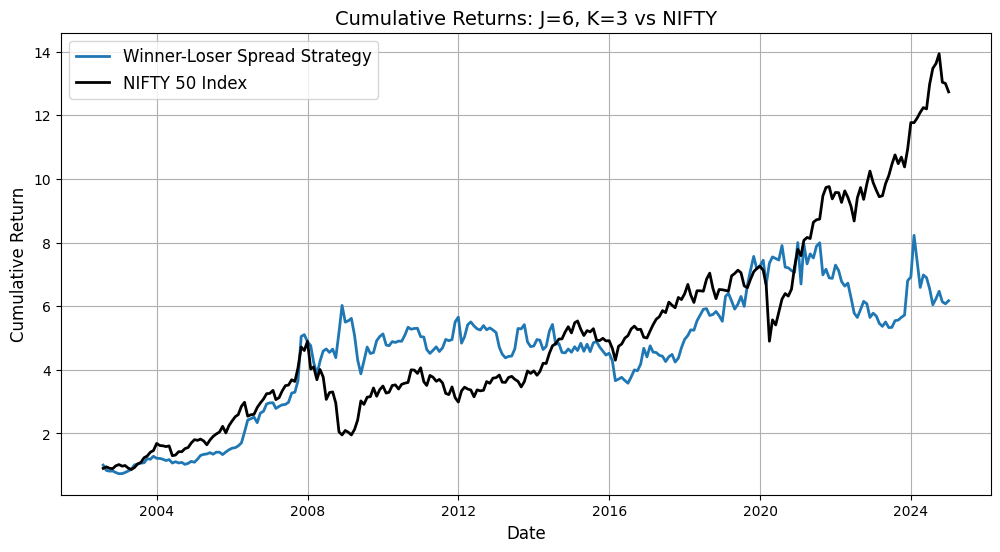


Results exported successfully to: JK_Strategy_Best_J6_K3_Results_20250317_130313.xlsx


In [ ]:
# --- Define J and K lists ---
J_list, K_list = [1,3,6,9,12], [1,3,6,9,12]  # You can adjust these lists
jk_pairs = list(itertools.product(J_list, K_list))

# --- Initialize summary list and portfolio storage ---
summary_matrix = []
portfolios_dict = {}  # To store portfolios for each (J, K)

# --- Run strategy, calculate returns, and store portfolios and summary ---
for J, K in jk_pairs:
    portfolios = run_jk_strategy(stock_df, J, K, custom_end_date)
    if not portfolios:
        print(f"Skipping J={J}, K={K}: No valid portfolios.")
        continue

    winner_df, loser_df = calculate_monthly_returns(stock_df, portfolios)
    final_df = pd.merge(winner_df, loser_df, on='Date')

    avg_winner = final_df['Winner Portfolio Avg Return'].mean()
    avg_loser = final_df['Loser Portfolio Avg Return'].mean()
    spread = avg_winner - avg_loser

    summary_matrix.append([
        int(J), int(K), round(avg_winner, 4), round(
            avg_loser, 4), round(spread, 4)
    ])

    # Store portfolios for later retrieval
    portfolios_dict[(J, K)] = portfolios

# --- If results exist, process summary ---
if summary_matrix:
    summary_df = pd.DataFrame(summary_matrix, columns=[
        'J', 'K', 'Avg Winner Return (%)', 'Avg Loser Return (%)', 'Spread (Winner - Loser) (%)'
    ])
    display(summary_df)

    # Find max spread row
    max_row = summary_df.loc[summary_df['Spread (Winner - Loser) (%)'].idxmax()]
    print("\nMaximum Spread Result:")
    print(f"J = {int(max_row['J'])}, K = {int(max_row['K'])}")
    print(f"Average Winner Return (%): {max_row['Avg Winner Return (%)']}")
    print(f"Average Loser Return (%): {max_row['Avg Loser Return (%)']}")
    print(
        f"Spread (Winner - Loser) (%): {max_row['Spread (Winner - Loser) (%)']}")

    # --- Retrieve best portfolios directly from dictionary ---
    best_J = int(max_row['J'])
    best_K = int(max_row['K'])
    best_portfolios = portfolios_dict[(best_J, best_K)]

    # Calculate monthly returns for best portfolios
    winner_df_best, loser_df_best = calculate_monthly_returns(
        stock_df, best_portfolios)
    final_df_best = pd.merge(winner_df_best, loser_df_best, on='Date')

    # --- Plot cumulative returns of spread vs NIFTY ---
    plot_cumulative_returns_for_best_jk(
        final_df_best, nifty_df, best_J, best_K)

    # --- Export best J/K results to Excel ---
    export_best_jk_results_to_excel(final_df_best, best_J, best_K)

else:
    print("\nNo valid results to display.")